## Web References

### System

- [How to copy a file without using scp inside an ssh session?](https://superuser.com/questions/291423/how-to-copy-a-file-without-using-scp-inside-an-ssh-session)

### PySpark

- [Complete Machine Learning Project with PySpark MLlib Tutorial](https://www.youtube.com/watch?v=1a7bB1ZcZ3k)
- [The ONLY PySpark Tutorial You Will Ever Need.](https://www.youtube.com/watch?v=cZS5xYYIPzk)
- [PySpark When Otherwise | SQL Case When Usage](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)
- [Spark rlike() Working with Regex Matching Examples](https://sparkbyexamples.com/spark/spark-rlike-regex-matching-examples/)
- [spark dataframe drop duplicates and keep first](https://stackoverflow.com/questions/38687212/spark-dataframe-drop-duplicates-and-keep-first)
- [Spark SQL Window functions using plain SQL](https://www.linkedin.com/pulse/spark-sql-window-functions-using-plain-ram-ghadiyaram/)
- [Calculate difference with previous row in PySpark](https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html)
- [forward fill with last observation for a DataFrame](https://stackoverflow.com/questions/36019847/pyspark-forward-fill-with-last-observation-for-a-dataframe)
- [Imputer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)

### Pandas

- [Pandas resample() tricks you should know for manipulating time-series data](https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3)
- [Resample with categories in pandas, keep non-numerical columns](https://stackoverflow.com/questions/56001927/resample-with-categories-in-pandas-keep-non-numerical-columns)

### Time Series

- [Time Series Analysis with Spark](https://www.youtube.com/watch?v=tKkneWcAIqU)
- [Time Series Stream Processing with Spark and Cassandra](https://www.youtube.com/watch?v=fBWLzB0FMX4)
- [Spark Basics: Missing Data and Time Series](https://www.youtube.com/watch?v=kvLCxHvL7U0)
- [Spark Resampling, Spark UDFs, Resampling Time Series Data with Spark](https://www.youtube.com/watch?v=uFws-jPywmc)

### Anomaly Detection

- [How to Build an Anomaly Detection Engine with Spark, Akka and Cassandra](https://learning.oreilly.com/videos/how-to-build/9781491955253/9781491955253-video244545/)
- [Real Time Detection of Anomalies in the Database Infrastructure using Apache Spark](https://www.youtube.com/watch?v=1IsMMmug5q0)

### Other

- [What is CRISP DM?](https://www.datascience-pm.com/crisp-dm-2/)

### Internet Traffic

- [Data mining approach for predicting the daily Internet data traffic of a smart university](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0176-5)

## Import Libraries

In [1]:
import datetime
import calendar
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, asc, desc, col, lag, isnull, from_unixtime, year, month, dayofmonth, dayofweek, hour, minute
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

## HDFS Preparation

In [2]:
%%bash
#!/bin/bash

# delete the 
if hadoop fs -test -d router; then
    # delete the output directory
    hadoop fs -rm -r router/output

    # create a new output directory
    hadoop fs -mkdir router/output
else
    # create the router directory and upload the input files
    hadoop fs -mkdir router
    hadoop fs -mkdir router/sample
    hadoop fs -put data/bandwidth.csv router/sample/

    hadoop fs -put data/raw router/raw

    # create the output directory
    hadoop fs -mkdir router/output
fi

hadoop fs -ls router/raw

Deleted router/output
Found 770 items
-rw-r--r--   3 jfoul001 users     150806 2022-03-10 06:46 router/raw/20220304T2210.csv.gz
-rw-r--r--   3 jfoul001 users     149945 2022-03-10 06:46 router/raw/20220304T2220.csv.gz
-rw-r--r--   3 jfoul001 users     149142 2022-03-10 06:46 router/raw/20220304T2230.csv.gz
-rw-r--r--   3 jfoul001 users     151781 2022-03-10 06:46 router/raw/20220304T2240.csv.gz
-rw-r--r--   3 jfoul001 users     150343 2022-03-10 06:46 router/raw/20220304T2250.csv.gz
-rw-r--r--   3 jfoul001 users     149798 2022-03-10 06:46 router/raw/20220304T2300.csv.gz
-rw-r--r--   3 jfoul001 users     148781 2022-03-10 06:46 router/raw/20220304T2310.csv.gz
-rw-r--r--   3 jfoul001 users     148639 2022-03-10 06:46 router/raw/20220304T2320.csv.gz
-rw-r--r--   3 jfoul001 users     149012 2022-03-10 06:46 router/raw/20220304T2330.csv.gz
-rw-r--r--   3 jfoul001 users     150019 2022-03-10 06:46 router/raw/20220304T2340.csv.gz
-rw-r--r--   3 jfoul001 users     150122 2022-03-10 06:46 rout

## Initialize the Spark Session

In [3]:
spark = SparkSession.builder.appName('cw02').getOrCreate()
spark

Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## I. Data Understanding

Identify, collect, and analyze the data sets that will help accomplish the project goals

### A. Collect Initial Data

In [4]:
#input_path = 'router/sample/bandwidth.csv'
input_path = 'router/raw/'

# read the full batch to process
df_batch = spark.read.csv(input_path, header=False, inferSchema=True) \
    .toDF('direction','interval_length','intervals_saved','ip','interval_start','interval_end','bytes_used')

In [5]:
# drop the intervals saved column
df_batch = df_batch.drop('intervals_saved')
print(f'Row Count: {df_batch.count():,}')

Row Count: 15,860,678


Remove records related to a specific upload or download class. This is done because this information is not relevant to the project, and have an additional column that will complicate data processing.

In [6]:
df_batch_preproc = df_batch.where(df_batch['interval_length'].contains('class_') == False)
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 12,968,172


### B. Describe data

Examine the data and document its surface properties like data format, number of records, or field identities.

#### 1. Data Format

In [7]:
df_batch_preproc.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)



In [8]:
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 12,968,172


#### 2. Remove Duplicates

Many duplicate records are present in the raw data since the data snapshots overlaps.

In [9]:
# drop duplicates
df_unique = df_batch_preproc.drop_duplicates()
print(f'Row Count: {df_unique.count():,}')

Row Count: 2,386,532


There are duplicates where only the `Bytes Used` field is different due to when the data snapshot was taken.

In [10]:
df_unique = df_unique.groupBy(['direction','interval_length','ip','interval_start','interval_end']) \
    .max('bytes_used') \
    .withColumnRenamed('max(bytes_used)', 'bytes_used')

print(f'Row Count: {df_unique.count():,}')

Row Count: 2,296,176


In [11]:
df_unique.show(5)

+---------+---------------+-------------+--------------+------------+----------+
|direction|interval_length|           ip|interval_start|interval_end|bytes_used|
+---------+---------------+-------------+--------------+------------+----------+
|   upload|              2|192.168.1.108|    1646652812|  1646652814|         0|
|   upload|              2| 192.168.1.11|    1646642370|  1646642372|      4280|
| download|         minute|192.168.3.224|    1646676600|  1646676660|         0|
|   upload|              2| 192.168.1.11|    1646653978|  1646653980|         0|
| download|              2|192.168.1.108|    1646647972|  1646647974|         0|
+---------+---------------+-------------+--------------+------------+----------+
only showing top 5 rows



### C. Explore data

Dig deeper into the data. Query it, visualize it, and identify relationships among the data.

#### 1. Unique Categories

In [12]:
# if an IP address is stored in the IP column recode it as simply 'IP'
df_interval_type = df_unique.withColumn('interval_type', 
    when(df_unique['ip']
    .rlike('^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'), 'IP')
    .otherwise(df_unique['ip'])
)

df_interval_type.groupBy(['interval_type']).count().show()

+-------------+-------+
|interval_type|  count|
+-------------+-------+
|           IP|1801786|
|     COMBINED| 494390|
+-------------+-------+



In [13]:
# record count per catergory
df_interval_type.groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+-------+
|interval_length|interval_type|  count|
+---------------+-------------+-------+
|            180|     COMBINED|   8072|
|              2|     COMBINED| 464266|
|              2|           IP|1442975|
|           7200|     COMBINED|    976|
|            900|     COMBINED|   2106|
|            900|           IP|  48166|
|            day|     COMBINED|    752|
|            day|           IP|   4452|
|           hour|     COMBINED|    538|
|           hour|           IP|  15046|
|         minute|     COMBINED|  17658|
|         minute|           IP| 288262|
|          month|     COMBINED|     22|
|          month|           IP|   2885|
+---------------+-------------+-------+



#### 2. How many intervals are available for the various categories?

This number should be less as for every interval there could be multiple IP addresses (where `interval_type == 'IP'`).

In [14]:
df_interval_type.drop_duplicates(['direction', 'interval_length', 'interval_type', 'interval_start', 'interval_end']) \
    .groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|interval_length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  8072|
|              2|     COMBINED|464266|
|              2|           IP|464465|
|           7200|     COMBINED|   976|
|            900|     COMBINED|  2106|
|            900|           IP|  2106|
|            day|     COMBINED|   752|
|            day|           IP|    84|
|           hour|     COMBINED|   538|
|           hour|           IP|   538|
|         minute|     COMBINED| 17658|
|         minute|           IP| 16960|
|          month|     COMBINED|    22|
|          month|           IP|    28|
+---------------+-------------+------+



#### 3. Minute Plot

Group the minute data by interval and show a line plot of the first twho hours for a visual overview of the data.

In [15]:
# get the summarized data
df_interval_bandwidth = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP')) \
    .groupBy(['interval_start']) \
    .sum('bytes_used') \
    .orderBy(['interval_start'], ascending=True) \
    .withColumnRenamed('sum(bytes_used)', 'bytes_used') \
    .limit(2 * 60) \
    .toPandas()

df_interval_bandwidth.describe()

,bytes_used
count,1.200000e+02
mean,2.216871e+07
std,3.043667e+07
min,4.337154e+06
25%,7.530486e+06
50%,9.770354e+06
75%,1.722035e+07
max,1.445253e+08


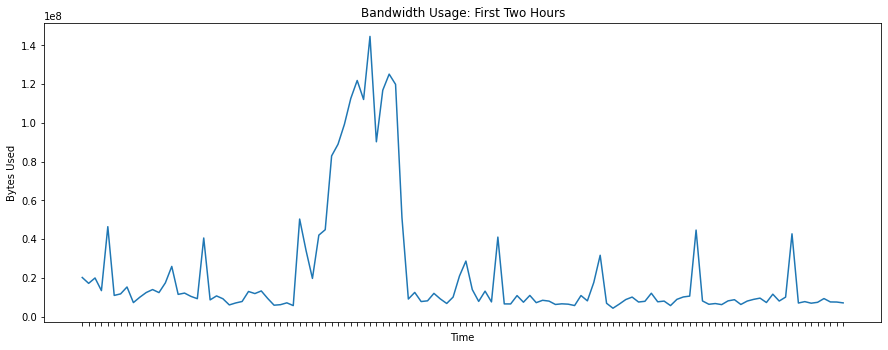

In [16]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_bandwidth,
    x='interval_start',
    y='bytes_used',
    ax=ax
).set(
    title='Bandwidth Usage: First Two Hours',
    ylabel='Bytes Used',
    xlabel='Time',
    xticklabels=[])

plt.show()

#### 4. Number of IP addresses in the last two hours

Notes:

- To count the number of local IP addresses use the `startswith` filter of `192.`
- The dataset contains incomplete intervals where `Interval End == 0` to indicate that the interval was not yet complete when the snapshot was taken.

In [17]:
# the filter on IP is to select only local IP addresses
df_interval_clients = spark.createDataFrame(df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           (df_interval_type['ip'].startswith('192.')) &
           (df_interval_type['interval_end'] > 0)) \
    .drop_duplicates(['ip', 'interval_start', 'interval_end']) \
    .groupBy(['interval_start']) \
    .count() \
    .orderBy(['interval_start'], ascending=True) \
    .tail(2 * 60)) \
    .toPandas()

df_interval_clients.describe()

,count
count,120.000000
mean,5.133333
std,2.637587
min,3.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,16.000000


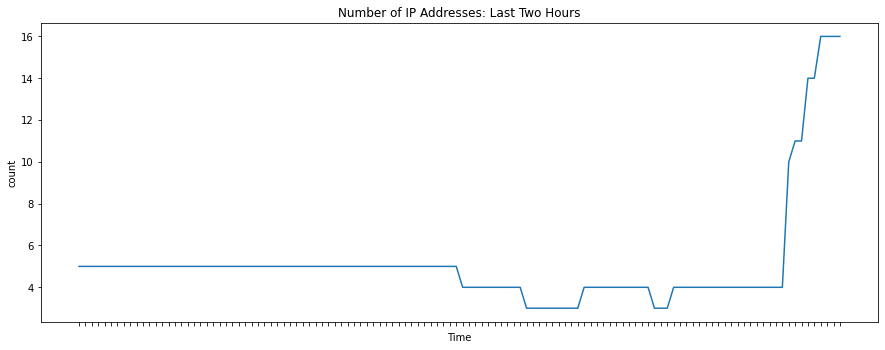

In [18]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_clients,
    x='interval_start',
    y='count',
    ax=ax
).set(
    title='Number of IP Addresses: Last Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

### D. Verify data quality

#### 1. Select only data by minute with an IP address

In [19]:
df_minute = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           ((df_interval_type['interval_end'] > 0))) 

print(f'Row Count: {df_minute.count():,}')

Row Count: 261,741


In [20]:
# verify that no null values are present in the dataset
assert df_minute.count() == df_minute.dropna().count()

In [21]:
# save the dataset to HDFS
df_minute.write.parquet('router/output/minute', mode='overwrite', compression='gzip')

#### 2. Find data gaps

In [22]:
# get the unique intervals
df_unique_intervals = df_minute \
    .drop_duplicates(['interval_start', 'interval_end']) \
    .drop('direction') \
    .drop('interval_length') \
    .drop('interval_end') \
    .drop('ip') \
    .drop('bytes_used') \
    .drop('interval_type')

interval_window = Window.partitionBy().orderBy('interval_start')

# add the previous interval start value
df_prev = df_unique_intervals \
    .withColumn('prev_interval_start', lag('interval_start', 1).over(interval_window))

# calculate the difference
df_prev = df_prev \
    .withColumn('diff', when(isnull(df_prev.prev_interval_start), 0) \
                       .otherwise(df_prev['interval_start'] - df_prev['prev_interval_start']))


df_prev.show(10)


+--------------+-------------------+----+
|interval_start|prev_interval_start|diff|
+--------------+-------------------+----+
|    1646430900|               null| 0.0|
|    1646430960|         1646430900|60.0|
|    1646431020|         1646430960|60.0|
|    1646431080|         1646431020|60.0|
|    1646431140|         1646431080|60.0|
|    1646431200|         1646431140|60.0|
|    1646431260|         1646431200|60.0|
|    1646431320|         1646431260|60.0|
|    1646431380|         1646431320|60.0|
|    1646431440|         1646431380|60.0|
+--------------+-------------------+----+
only showing top 10 rows



In [23]:
df_prev.select('diff').summary().show()

+-------+------------------+
|summary|              diff|
+-------+------------------+
|  count|              7710|
|   mean| 60.03112840466926|
| stddev|3.4843483623995377|
|    min|               0.0|
|    25%|              60.0|
|    50%|              60.0|
|    75%|             360.0|
|    max|             360.0|
+-------+------------------+



In [24]:
df_prev.where('diff > 60').show()

+--------------+-------------------+-----+
|interval_start|prev_interval_start| diff|
+--------------+-------------------+-----+
|    1646574900|         1646574540|360.0|
+--------------+-------------------+-----+



## II. Data Preparation

### A. Select Data

In [25]:
# load the dataset form the previous section
df_source = spark.read.parquet('router/output/minute')
print(f'Row Count: {df_source.count():,}')

Row Count: 261,741


In [26]:
df_source.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)
 |-- interval_type: string (nullable = true)



### B. Clean Data

#### 1. Remove the `interval_type` and `interval_length` columns

In [27]:
df_minute = df_source \
    .drop('interval_type') \
    .drop('interval_length')

df_minute.show(5)

+---------+-------------+--------------+------------+----------+
|direction|           ip|interval_start|interval_end|bytes_used|
+---------+-------------+--------------+------------+----------+
|   upload|192.168.3.242|    1646599020|  1646599080|    468664|
|   upload|192.168.3.125|    1646530380|  1646530440|      4531|
|   upload|192.168.3.168|    1646604420|  1646604480|         0|
|   upload| 192.168.1.11|    1646571960|  1646572020|      5348|
| download|192.168.3.246|    1646522820|  1646522880|      4755|
+---------+-------------+--------------+------------+----------+
only showing top 5 rows



#### 2. Add a `time` columns from the interval start end end epoch

In [28]:
# convert epoch columns to datetime
df_minute = df_minute \
    .withColumn('interval_start_time', from_unixtime(df_minute['interval_start'])) \
    .withColumn('interval_end_time', from_unixtime(df_minute['interval_end']))

df_minute.show(5)

+---------+-------------+--------------+------------+----------+-------------------+-------------------+
|direction|           ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|
+---------+-------------+--------------+------------+----------+-------------------+-------------------+
|   upload|192.168.3.242|    1646599020|  1646599080|    468664|2022-03-06 20:37:00|2022-03-06 20:38:00|
|   upload|192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|
|   upload|192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 22:07:00|2022-03-06 22:08:00|
|   upload| 192.168.1.11|    1646571960|  1646572020|      5348|2022-03-06 13:06:00|2022-03-06 13:07:00|
| download|192.168.3.246|    1646522820|  1646522880|      4755|2022-03-05 23:27:00|2022-03-05 23:28:00|
+---------+-------------+--------------+------------+----------+-------------------+-------------------+
only showing top 5 rows



### C. Construct Data

#### 1. Add Date Features

In [29]:
df_minute_date = df_minute \
    .withColumn('year', year(df_minute['interval_start_time'])) \
    .withColumn('month', month(df_minute['interval_start_time'])) \
    .withColumn('day', dayofmonth(df_minute['interval_start_time'])) \
    .withColumn('day_of_week', dayofweek(df_minute['interval_start_time'])) \
    .withColumn('hour', hour(df_minute['interval_start_time'])) \
    .withColumn('minute', minute(df_minute['interval_start_time']))

df_minute_date.show(5)

+---------+-------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+
|direction|           ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|year|month|day|day_of_week|hour|minute|
+---------+-------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+
|   upload|192.168.3.242|    1646599020|  1646599080|    468664|2022-03-06 20:37:00|2022-03-06 20:38:00|2022|    3|  6|          1|  20|    37|
|   upload|192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|2022|    3|  6|          1|   1|    33|
|   upload|192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 22:07:00|2022-03-06 22:08:00|2022|    3|  6|          1|  22|     7|
|   upload| 192.168.1.11|    1646571960|  1646572020|      5348|2022-03-06 13:06:00|2022-03-06 13:07:00|2022|    3|  6|          1|  13|

#### 2. VLAN Feature

In [30]:
df_minute_vlan_all = df_minute_date \
    .withColumn('vlan', when(df_minute_date['ip'].startswith('192.168.1'), 'private') \
                        .when(df_minute_date['ip'].startswith('192.168.3'), 'tenants') \
                        .when(df_minute_date['ip'].startswith('192.168'), 'other') \
                        .otherwise('internal'))

df_minute_vlan_all.show(5)

+---------+-------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+-------+
|direction|           ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|year|month|day|day_of_week|hour|minute|   vlan|
+---------+-------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+-------+
|   upload|192.168.3.242|    1646599020|  1646599080|    468664|2022-03-06 20:37:00|2022-03-06 20:38:00|2022|    3|  6|          1|  20|    37|tenants|
|   upload|192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|2022|    3|  6|          1|   1|    33|tenants|
|   upload|192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 22:07:00|2022-03-06 22:08:00|2022|    3|  6|          1|  22|     7|tenants|
|   upload| 192.168.1.11|    1646571960|  1646572020|      5348|2022-03-06 13:06:00|2022

In [31]:
# summary of networks in the dataset
df_distinct_ip = df_minute_vlan_all \
    .select('ip', 'vlan') \
    .distinct()

df_distinct_ip.groupBy('vlan').count().show()

+--------+-----+
|    vlan|count|
+--------+-----+
| tenants|   22|
|internal|    2|
| private|   11|
+--------+-----+



- `197.95.152.171` is the public IP of the switch.
- `172.17.0.2` is the internal IP address of the router.

In [32]:
df_distinct_ip.where('vlan == "internal"').show()

+--------------+--------+
|            ip|    vlan|
+--------------+--------+
|197.94.242.117|internal|
|    172.17.0.2|internal|
+--------------+--------+



In [33]:
# how much data are used by the vlan categories
df_summary_vlan = df_minute_vlan_all \
    .groupBy('direction', 'vlan') \
    .sum('bytes_used') \
    .orderBy('direction', 'vlan') \


df_summary_vlan.show()


+---------+--------+---------------+
|direction|    vlan|sum(bytes_used)|
+---------+--------+---------------+
| download|internal|       94137372|
| download| private|    52091745442|
| download| tenants|   118013924491|
|   upload|internal|       40795153|
|   upload| private|     5201201786|
|   upload| tenants|    17504683089|
+---------+--------+---------------+



[Text(0.5, 1.0, 'Bandwidth Usage by VLAN'),
 Text(0, 0.5, 'Bytes Used'),
 Text(0.5, 0, 'VLAN')]

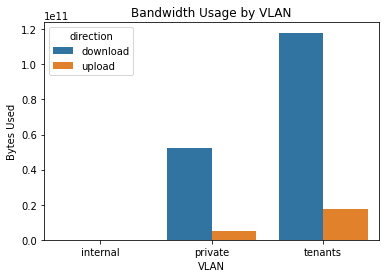

In [34]:
# plot the vlan summary
sns.barplot(
    data=df_summary_vlan.toPandas(),
    x='vlan',
    y='sum(bytes_used)',
    hue='direction'
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Bytes Used',
    xlabel='VLAN'
)

In [35]:
# remove the internal ip addresses form the dataset
df_minute_vlan = df_minute_vlan_all \
    .where('vlan != "internal"')

print(f'Row Count: {df_minute_vlan.count():,}')

Row Count: 244,931


##### Daily Bandwidth Usage

In [36]:
# get the summary data
df_daily_summary = df_minute_vlan \
    .groupBy('year', 'month', 'day', 'vlan') \
    .sum('bytes_used') \
    .orderBy('year', 'month', 'day', 'vlan').toPandas()

df_daily_summary.head()

,year,month,day,vlan,sum(bytes_used)
0,2022,3,4,private,138364651
1,2022,3,4,tenants,2518310329
2,2022,3,5,private,13337844087
3,2022,3,5,tenants,21974716480
4,2022,3,6,private,9746012979


In [37]:
# add a date column
df_daily_summary['date'] = pd.to_datetime(df_daily_summary[['year', 'month', 'day']])
df_daily_summary.drop(columns=['year', 'month', 'day'], inplace=True)

df_daily_summary.head()

,vlan,sum(bytes_used),date
0,private,138364651,2022-03-04
1,tenants,2518310329,2022-03-04
2,private,13337844087,2022-03-05
3,tenants,21974716480,2022-03-05
4,private,9746012979,2022-03-06


In [38]:
# resample the data to fill gaps if present
df_daily_summary_resampled = df_daily_summary \
    .set_index('date') \
    .groupby('vlan') \
    .resample('D') \
    .sum() \
    .ffill() \
    .reset_index()

# add a gigabytes column
df_daily_summary_resampled['gigabytes'] = df_daily_summary_resampled['sum(bytes_used)'] / 1e9
#df_daily_summary_resampled.sort_values('vlan', inplace=True)

df_daily_summary_resampled.head(10)

,vlan,date,sum(bytes_used),gigabytes
0,private,2022-03-04,138364651,0.138365
1,private,2022-03-05,13337844087,13.337844
2,private,2022-03-06,9746012979,9.746013
3,private,2022-03-07,12818470359,12.818470
4,private,2022-03-08,9636907707,9.636908
5,private,2022-03-09,9629446249,9.629446
6,private,2022-03-10,1985901196,1.985901
7,tenants,2022-03-04,2518310329,2.518310
8,tenants,2022-03-05,21974716480,21.974716
9,tenants,2022-03-06,36606105290,36.606105


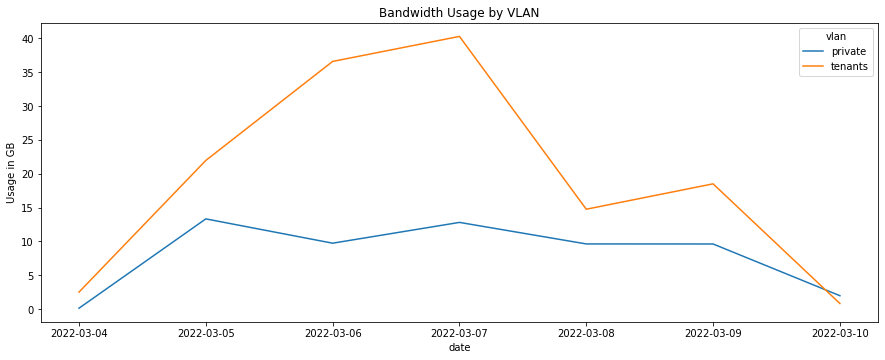

In [39]:
# configure the plot
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

# get x tick labels
x_dates = df_daily_summary_resampled['date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.lineplot(
    data=df_daily_summary_resampled,
    x='date',
    y='gigabytes',
    hue='vlan',
    ax=ax
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Usage in GB',
    xticks=df_daily_summary_resampled.date.unique()
)

plt.show()

##### Summarize by IP and total bytes used

In [40]:
# get the summarized data
df_total_usage = df_minute_vlan \
    .select('IP', 'vlan', 'bytes_used') \
    .groupBy('IP', 'vlan')\
    .sum() \
    .sort('sum(bytes_used)', ascending=False) \
    .toPandas()

df_total_usage['gigabytes'] = df_total_usage['sum(bytes_used)'] / 1e9
df_total_usage.head(10)

,IP,vlan,sum(bytes_used),gigabytes
0,192.168.3.126,tenants,34991308752,34.991309
1,192.168.1.108,private,31372581033,31.372581
2,192.168.3.185,tenants,26657317151,26.657317
3,192.168.3.224,tenants,16712013950,16.712014
4,192.168.3.103,tenants,15230307004,15.230307
5,192.168.1.189,private,11234166644,11.234167
6,192.168.3.125,tenants,10361077935,10.361078
7,192.168.3.111,tenants,7339077740,7.339078
8,192.168.1.186,private,7096251946,7.096252
9,192.168.3.246,tenants,6003659108,6.003659


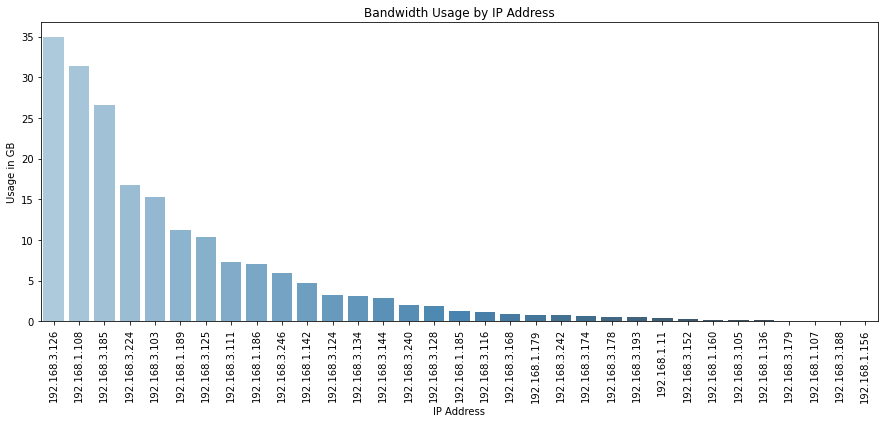

In [41]:
# plot the results
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(
    data=df_total_usage,
    x='IP',
    y='gigabytes',
    palette='Blues_d',
    ax=ax
).set(
    title='Bandwidth Usage by IP Address',
    ylabel='Usage in GB',
    xlabel='IP Address'
)

ax.tick_params(axis='x', rotation=90)
plt.show()

#### 3. Create Features for each IP Address

In [42]:
df_minute_vlan.printSchema()

root
 |-- direction: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)
 |-- interval_start_time: string (nullable = true)
 |-- interval_end_time: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- vlan: string (nullable = false)



In [43]:
# create the base users table
df_users = df_minute_vlan \
    .select('IP', 'vlan', 'bytes_used') \
    .groupBy('IP', 'vlan') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'total_bytes') \
    .sort('IP', ascending=False).toPandas()

print(f'Row Count: {df_users.shape[0]:,}')

Row Count: 33


In [44]:
# calculate the download bytes used
df_users_download = df_minute_vlan \
    .select('IP', 'bytes_used') \
    .where('direction == "download"') \
    .groupBy('IP') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'dowload_bytes') \
    .sort('IP', ascending=False).toPandas()

df_users = df_users.merge(df_users_download, on='IP', how='left')
df_users.head()

,IP,vlan,total_bytes,dowload_bytes
0,192.168.3.246,tenants,6003659108,4339881106
1,192.168.3.242,tenants,765143345,708025871
2,192.168.3.240,tenants,2074016853,1662128633
3,192.168.3.224,tenants,16712013950,16287389724
4,192.168.3.193,tenants,484145977,284428423


In [45]:
# calculate the upload bytes used
df_users_upload = df_minute_vlan \
    .select('IP', 'bytes_used') \
    .where('direction == "upload"') \
    .groupBy('IP') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'upload_bytes') \
    .sort('IP', ascending=False).toPandas()

df_users = df_users.merge(df_users_upload, on='IP', how='left')
df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002
1,192.168.3.242,tenants,765143345,708025871,57117474
2,192.168.3.240,tenants,2074016853,1662128633,411888220
3,192.168.3.224,tenants,16712013950,16287389724,424624226
4,192.168.3.193,tenants,484145977,284428423,199717554


##### Bandwidth usage by day of week

In [46]:
def get_dayofweek_usage(df_source, dayofweek):
    """
    Get the usage for a specific day of the week

    Parameters
    ----------
    df_source : pySpark dataframe
        The source dataframe
    dayofweek : int
        The day of the week to get the usage for

    Returns
    -------
    df_dayofweek : pySpark dataframe
        The dataframe with the day of the week usage
    """
    day_name = calendar.day_name[dayofweek - 1]

    df_dayofweek_usage = df_source \
        .select('IP', 'bytes_used') \
        .where(f'day_of_week == "{dayofweek}"') \
        .groupBy('IP') \
        .avg() \
        .withColumnRenamed('avg(bytes_used)', f'{day_name}_avg_bytes') \
        .sort('IP', ascending=False).toPandas()

    # change the average bytes to an integer
    df_dayofweek_usage[f'{day_name}_avg_bytes'] = \
        df_dayofweek_usage[f'{day_name}_avg_bytes'].astype(int)

    return df_dayofweek_usage

In [47]:
# calculate the average usage for each day of the week
for i in range(0, 7):
    df_dayofweek_usage = get_dayofweek_usage(df_minute_vlan, i+1)
    df_users = df_users.merge(df_dayofweek_usage, on='IP', how='left')

df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,Sunday_avg_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,NaN,NaN,132844.0,1143805.0
1,192.168.3.242,tenants,765143345,708025871,57117474,110405.0,15476.0,70635.0,69328.0,19014.0,13308.0,16132.0
2,192.168.3.240,tenants,2074016853,1662128633,411888220,12195.0,25176.0,336888.0,341015.0,21219.0,65170.0,351155.0
3,192.168.3.224,tenants,16712013950,16287389724,424624226,NaN,9517041.0,24160.0,2962873.0,2210.0,NaN,NaN
4,192.168.3.193,tenants,484145977,284428423,199717554,NaN,11884.0,NaN,1742181.0,NaN,NaN,NaN


In [48]:
# replace the NaN values with 0
df_users.fillna(0, inplace=True)
df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,Sunday_avg_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,0.0,0.0,132844.0,1143805.0
1,192.168.3.242,tenants,765143345,708025871,57117474,110405.0,15476.0,70635.0,69328.0,19014.0,13308.0,16132.0
2,192.168.3.240,tenants,2074016853,1662128633,411888220,12195.0,25176.0,336888.0,341015.0,21219.0,65170.0,351155.0
3,192.168.3.224,tenants,16712013950,16287389724,424624226,0.0,9517041.0,24160.0,2962873.0,2210.0,0.0,0.0
4,192.168.3.193,tenants,484145977,284428423,199717554,0.0,11884.0,0.0,1742181.0,0.0,0.0,0.0


##### Visualize the top 10 to see if they will be separable

In [84]:
# create a dataframe suitable for creating the plot
df_day_plot = df_users.rename(columns=lambda x: x.replace('_avg_bytes', '')).head(10)

df_day_plot = df_day_plot.melt(
    id_vars=list(df_users.columns)[:-7], 
    var_name='day_of_week', 
    value_name='avg_bytes')

df_day_plot.sample(n=5, random_state=5)

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,day_of_week,avg_bytes
34,192.168.3.193,tenants,484145977,284428423,199717554,Thursday,1742181.0
48,192.168.3.178,tenants,540382287,520417869,19964418,Friday,0.0
28,192.168.3.178,tenants,540382287,520417869,19964418,Wednesday,0.0
67,192.168.3.179,tenants,30482126,24614818,5867308,Sunday,15014.0
10,192.168.3.246,tenants,6003659108,4339881106,1663778002,Tuesday,731149.0


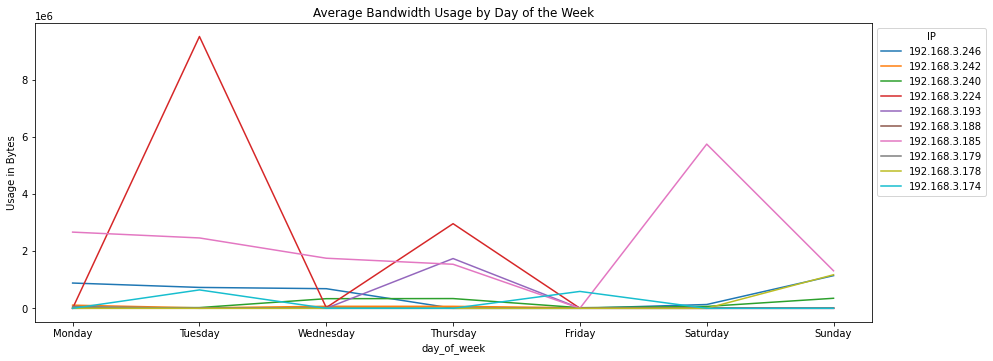

In [85]:

fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_day_plot,
    x='day_of_week',
    y='avg_bytes',
    hue='IP',
    ax=ax
).set(
    title='Average Bandwidth Usage by Day of the Week',
    ylabel='Usage in Bytes')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
